### Download dataset from:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Import library
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers
from keras.utils.vis_utils import plot_model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [5]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [6]:
# root path
root = 'dataset/'

In [7]:
# dataframe
Normal_train=pd.DataFrame(os.listdir(root+'train/NORMAL/'), columns=['Imagen'])
Normal_train['path']=root+'train/NORMAL/'+Normal_train['Imagen']
Pneumonia_train=pd.DataFrame(os.listdir(root+'train/PNEUMONIA/'), columns=['Imagen'])
Pneumonia_train['path']=root+'train/PNEUMONIA/'+Pneumonia_train['Imagen']

In [8]:
nm=('Normal,'*Normal_train.shape[0]).split(',')[:-1]
pm=('Pneumonia,'*Pneumonia_train.shape[0]).split(',')[:-1]

In [9]:
Normal_train['class']=nm
Pneumonia_train['class']=pm

In [10]:
Normal_train.head(3)

,Imagen,path,class
0,IM-0115-0001.jpeg,dataset/train/NORMAL/IM-0115-0001.jpeg,Normal
1,IM-0117-0001.jpeg,dataset/train/NORMAL/IM-0117-0001.jpeg,Normal
2,IM-0119-0001.jpeg,dataset/train/NORMAL/IM-0119-0001.jpeg,Normal


In [11]:
Pneumonia_train.head(3)

,Imagen,path,class
0,person1000_bacteria_2931.jpeg,dataset/train/PNEUMONIA/person1000_bacteria_29...,Pneumonia
1,person1000_virus_1681.jpeg,dataset/train/PNEUMONIA/person1000_virus_1681....,Pneumonia
2,person1001_bacteria_2932.jpeg,dataset/train/PNEUMONIA/person1001_bacteria_29...,Pneumonia


In [12]:
# shape dataset
# Unbalanced data, ratio 1:3
Normal_train.shape, Pneumonia_train.shape

((1341, 3), (3875, 3))

In [13]:
df=Normal_train.append(Pneumonia_train).reset_index(drop=True)
df.tail(2)

,Imagen,path,class
5214,person9_bacteria_40.jpeg,dataset/train/PNEUMONIA/person9_bacteria_40.jpeg,Pneumonia
5215,person9_bacteria_41.jpeg,dataset/train/PNEUMONIA/person9_bacteria_41.jpeg,Pneumonia


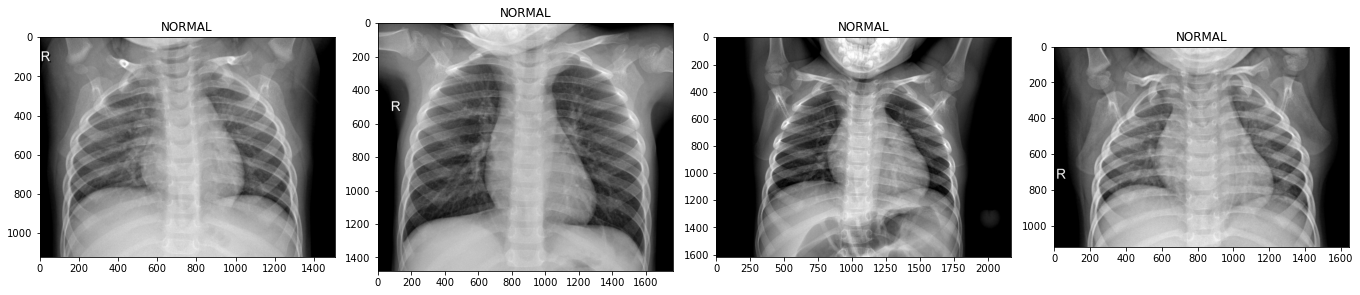

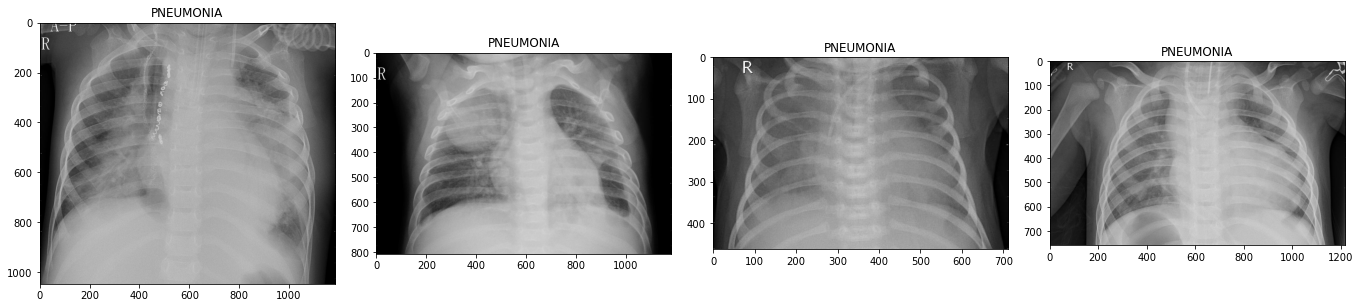

In [14]:
plt.figure(figsize = (19, 6))
i=1
for _, row in Normal_train.sample(4).iterrows():
    ax=plt.subplot(1,4,i)
    im=root+'train/NORMAL/'+row.values[0]
    img = cv2.imread(im)
    plt.imshow(img)
    plt.tight_layout()
    plt.title('NORMAL')
    i+=1;
    
plt.figure(figsize = (19, 6))
i=1
for _, row in Pneumonia_train.sample(4).iterrows():
    ax=plt.subplot(1,4,i)
    im=root+'train/PNEUMONIA/'+row.values[0]
    img = cv2.imread(im)
    plt.imshow(img)
    plt.tight_layout()
    plt.title('PNEUMONIA')
    i+=1;

In [15]:
df['class'].values

array(['Normal', 'Normal', 'Normal', ..., 'Pneumonia', 'Pneumonia',
       'Pneumonia'], dtype=object)

In [16]:
# label encoder (class)
y_train=LabelEncoder().fit_transform(df['class'].values)
y_train

array([0, 0, 0, ..., 1, 1, 1])

## Convolutional Neural Network (CNN)

In [17]:
# epochs
epochs_val = 20

# batch_size
batch_size_val = 32

# target_size
#224
target_size_val=(75,75)

# input_shape
input_shape_val = (target_size_val[0],target_size_val[1], 3)

In [18]:
# min-max image values
img.min(), img.max()

(0, 255)

### Datagen

In [19]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    preprocessing_function=None)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### Data Generator

In [20]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(root+'train/',
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(root+'val/',
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'binary')

# Test 
test_generator = validation_datagen.flow_from_directory(root+'test/',
                                 target_size=target_size_val,
                                 shuffle = False,
                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [21]:
# Train Data Generator from DataFrame
train_generator_df = train_datagen.flow_from_dataframe(dataframe=df, 
                                              x_col='path', 
                                              y_col='class', 
                                              target_size=target_size_val,      
                                              batch_size=batch_size_val,
                                              class_mode = 'binary')

Found 5216 validated image filenames belonging to 2 classes.


### plot images of train_generator

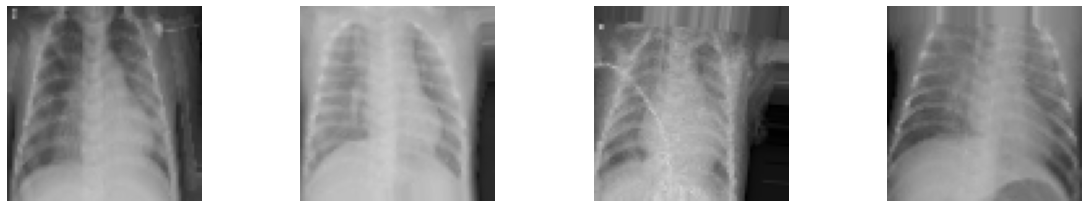

In [23]:
# plot image of train_generator
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(19,3))
for i in range(4):
  im = next(train_generator)[0][i]
  # (n, x, y, 3) to (x, y, 3)
  im = np.squeeze(im)
  # plot raw pixel data
  ax[i].imshow(im)
  ax[i].axis('off')
  plt.tight_layout()

### Models

In [24]:
# Custom model

model_custom = models.Sequential()
model_custom.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape=input_shape_val))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Conv2D(64, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Conv2D(64, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Flatten())
model_custom.add(Dense(units = 64, activation = 'relu'))
model_custom.add(Dropout(0.2))
model_custom.add(Dense(units = 32, activation = 'relu'))
model_custom.add(Dropout(0.2))

model_custom.add(Dense(1, activation = 'sigmoid'))

# name
model_custom._name = "model_custom"
# summary
#model_custom.summary()

2022-04-25 23:30:01.230288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 23:30:01.276331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 23:30:01.277117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 23:30:01.278568: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [25]:
#plot_model(model_custom, to_file = 'model_custom.png', show_shapes = True, show_layer_names = True)

In [26]:
# Model VGG19
## from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input ?? preprocess_input??
model_vgg19 = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = input_shape_val)

for layer in model_vgg19.layers:
    layer.trainable=False
    
x = model_vgg19.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_vgg19 = Dense(1, activation='sigmoid')(x)

# model
model_vgg19 = tf.keras.Model(inputs=model_vgg19.input, outputs=output_vgg19)

# name
model_vgg19._name = "model_vgg19"
# summary
#model_vgg19.summary()

In [27]:
# Model Resnet

model_resnet = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = input_shape_val)

for layer in model_resnet.layers:
    layer.trainable=False
    
x = model_resnet.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_resnet = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model
model_resnet = tf.keras.Model(inputs=model_resnet.input, outputs=output_resnet)

# name
model_resnet._name = "model_resnet"
# summary
#model_resnet.summary()

In [28]:
# Model inception_v3

model_inception_v3 = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top = False, input_shape = input_shape_val)

for layer in model_inception_v3.layers:
    layer.trainable=False
    
x = model_inception_v3.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_inception_v3 = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model
model_inception_v3 = tf.keras.Model(inputs=model_inception_v3.input, outputs=output_inception_v3)

# name
model_inception_v3._name = "model_inception_v3"
# summary
#model_inception_v3.summary()

In [29]:
# Model EfficientNet

model_EfficientNet = tf.keras.applications.EfficientNetB7(
    weights='imagenet', include_top = False, input_shape = input_shape_val)

for layer in model_EfficientNet.layers:
    layer.trainable=False
    
x = model_EfficientNet.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_EfficientNet = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model
model_EfficientNet = tf.keras.Model(inputs=model_EfficientNet.input, outputs=output_EfficientNet)

# name
model_EfficientNet._name = "model_EfficientNet"
# summary
#model_EfficientNet.summary()

### class_weight  -  optimizer - overfitting 

In [30]:
# class_weight - Unbalanced Data
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [31]:
# Define optimizer
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [32]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=4) 

### Compile and Fit models function

In [33]:
if os.path.exists('models/'):
    pass
else:
    os.makedirs('models/')

In [34]:
# run models fuction

filepath=os.getcwd()+'/models/'
def run_model(model):
    
    # save best model (callback)
    modelCheckpoint = ModelCheckpoint(filepath+'{}.h5'.format(model.name), save_best_only = True)
    
    # Compile the model
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
    
    # Fit the model
    history = model.fit_generator(generator=train_generator,
                              epochs = epochs_val,
                              steps_per_epoch=df.shape[0] // (batch_size_val*1),
                              callbacks=[early_stopping, lr, modelCheckpoint],
                              class_weight=class_weights,
                              validation_data = validation_generator)
    
    print(history.history.keys())
    
    return model, history

### Plot models function

In [35]:
def plot_model_output(history, name='model'):
    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Run and plot model

In [36]:
max_accuracy=[]

In [37]:
# Run model 
custom_model, history_custom = run_model(model_custom)
max_accuracy.append(('{}.h5'.format(custom_model.name),np.max(history_custom.history['accuracy'])))

Epoch 1/20


2022-04-25 23:30:14.632699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


163/163 [==============================] - 163s 978ms/step - loss: 0.5373 - accuracy: 0.6862 - val_loss: 0.5089 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 55s 336ms/step - loss: 0.3321 - accuracy: 0.8512 - val_loss: 0.5855 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 45s 279ms/step - loss: 0.2987 - accuracy: 0.8748 - val_loss: 0.5050 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 45s 278ms/step - loss: 0.2663 - accuracy: 0.8829 - val_loss: 0.5454 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - 47s 285ms/step - loss: 0.2528 - accuracy: 0.8882 - val_loss: 0.4997 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - 46s 285ms/step - loss: 0.2343 - accuracy: 0.8990 - val_loss: 0.4515 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/20
163/163 [==============================] - 46s 285m

In [38]:
# Run model 
vgg19_model, history_vgg19 = run_model(model_vgg19)
max_accuracy.append(('{}.h5'.format(vgg19_model.name),np.max(history_vgg19.history['accuracy'])))

Epoch 1/20
  1/163 [..............................] - ETA: 4:46 - loss: 0.7312 - accuracy: 0.3125

2022-04-25 23:47:44.243036: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-25 23:47:44.317406: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


163/163 [==============================] - ETA: 0s - loss: 0.3540 - accuracy: 0.8478

2022-04-25 23:48:30.335189: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-25 23:48:30.406022: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


163/163 [==============================] - 49s 291ms/step - loss: 0.3540 - accuracy: 0.8478 - val_loss: 0.5034 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - 50s 304ms/step - loss: 0.2708 - accuracy: 0.8813 - val_loss: 0.4712 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - 52s 320ms/step - loss: 0.2458 - accuracy: 0.8976 - val_loss: 0.4366 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - 52s 319ms/step - loss: 0.2263 - accuracy: 0.9057 - val_loss: 0.4838 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 5/20
163/163 [==============================] - 58s 354ms/step - loss: 0.2200 - accuracy: 0.9080 - val_loss: 0.4706 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 6/20
163/163 [==============================] - 52s 317ms/step - loss: 0.2169 - accuracy: 0.9053 - val_loss: 0.4193 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 7/20
163/163 [===================

In [39]:
# Run model
resnet_model, history_resnet = run_model(model_resnet)
max_accuracy.append(('{}.h5'.format(resnet_model.name),np.max(history_resnet.history['accuracy'])))

Epoch 1/20


2022-04-26 00:05:54.002051: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/163 [..............................] - ETA: 10:23 - loss: 1.9581 - accuracy: 0.5000

2022-04-26 00:05:54.358556: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-26 00:05:54.414052: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


163/163 [==============================] - ETA: 0s - loss: 1.5450 - accuracy: 0.5266

2022-04-26 00:06:59.969834: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-26 00:07:00.270669: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-26 00:07:00.316858: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


163/163 [==============================] - 71s 416ms/step - loss: 1.5450 - accuracy: 0.5266 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 2/20
163/163 [==============================] - 121s 743ms/step - loss: 1.5090 - accuracy: 0.5341 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 3/20
163/163 [==============================] - 126s 773ms/step - loss: 1.5150 - accuracy: 0.5282 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 4/20
163/163 [==============================] - 96s 585ms/step - loss: 1.5669 - accuracy: 0.5311 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 5/20
163/163 [==============================] - 87s 533ms/step - loss: 1.5374 - accuracy: 0.5311 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-04
Epoch 6/20
163/163 [==============================] - 163s 1s/step - loss: 1.5467 - accuracy: 0.5301 - val_loss: 1.5346 - val_accuracy: 0.3750 - lr: 1.0000e-05
Epoch 7/20
163/163 [===================

In [40]:
# Run model
inception_v3_model, history_inception_v3 = run_model(model_inception_v3)
max_accuracy.append(('{}.h5'.format(inception_v3_model.name),np.max(history_inception_v3.history['accuracy'])))

Epoch 1/20
163/163 [==============================] - 157s 844ms/step - loss: 0.5027 - accuracy: 0.7222 - val_loss: 0.6472 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 2/20
163/163 [==============================] - 81s 496ms/step - loss: 0.2852 - accuracy: 0.8875 - val_loss: 1.0344 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 3/20
163/163 [==============================] - 51s 311ms/step - loss: 0.2421 - accuracy: 0.9061 - val_loss: 1.1883 - val_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 4/20
163/163 [==============================] - 53s 327ms/step - loss: 0.2149 - accuracy: 0.9183 - val_loss: 0.3826 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 5/20
163/163 [==============================] - 51s 309ms/step - loss: 0.2050 - accuracy: 0.9193 - val_loss: 0.6298 - val_accuracy: 0.7500 - lr: 1.0000e-05
Epoch 6/20
163/163 [==============================] - 52s 321ms/step - loss: 0.1865 - accuracy: 0.9291 - val_loss: 0.6672 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 7/20
163/163 [=======

In [41]:
# Run model
EfficientNet_model, history_EfficientNet = run_model(model_EfficientNet)
max_accuracy.append(('{}.h5'.format(EfficientNet_model.name),np.max(history_EfficientNet.history['accuracy'])))

Epoch 1/20
163/163 [==============================] - 94s 450ms/step - loss: 0.7111 - accuracy: 0.4803 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 2/20
163/163 [==============================] - 62s 380ms/step - loss: 0.6980 - accuracy: 0.5012 - val_loss: 0.6936 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 3/20
163/163 [==============================] - 61s 374ms/step - loss: 0.6943 - accuracy: 0.5293 - val_loss: 0.6944 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 4/20
163/163 [==============================] - 64s 390ms/step - loss: 0.6952 - accuracy: 0.4624 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 5/20
163/163 [==============================] - 64s 391ms/step - loss: 0.6959 - accuracy: 0.4659 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 1.0000e-06
Epoch 6/20
163/163 [==============================] - 65s 399ms/step - loss: 0.6948 - accuracy: 0.4350 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-07
Epoch 7/20
163/163 [========

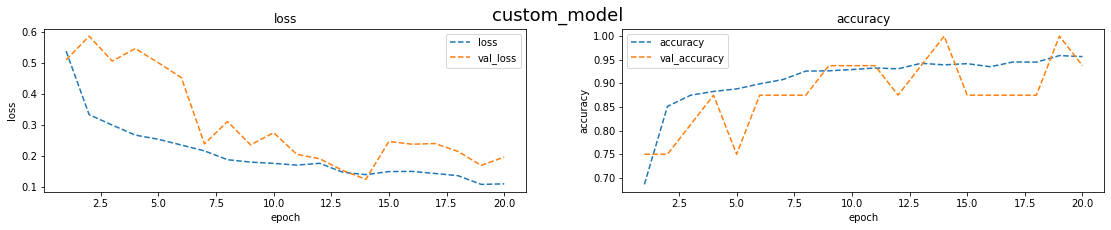

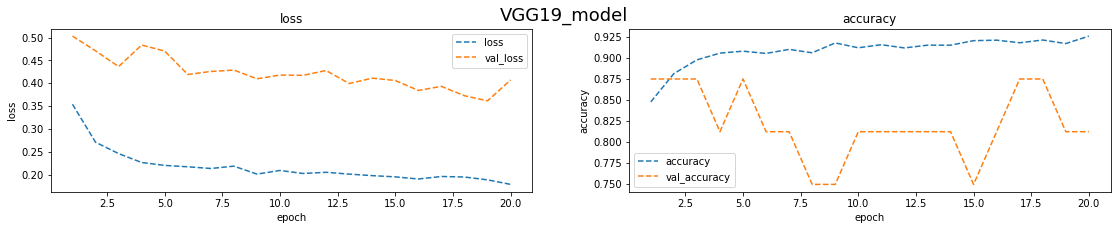

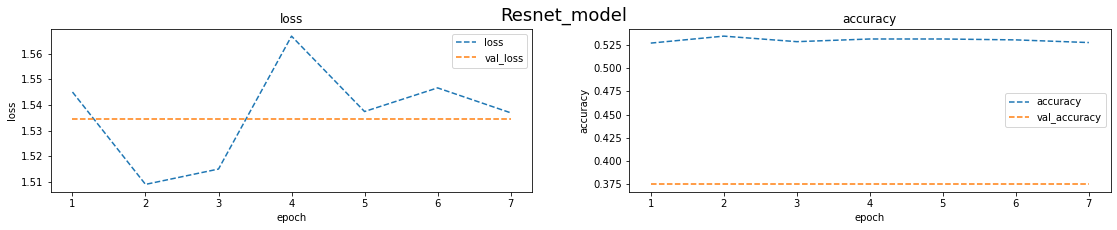

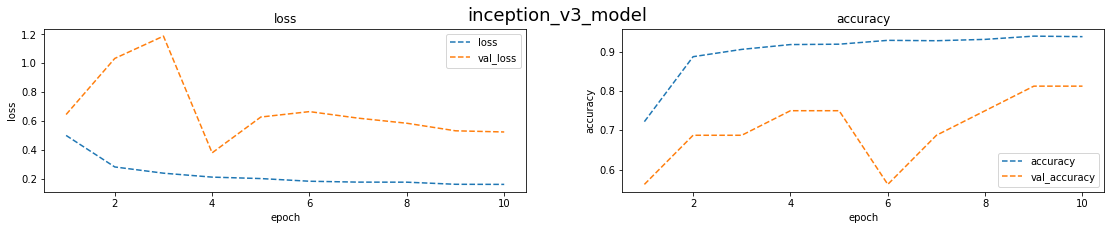

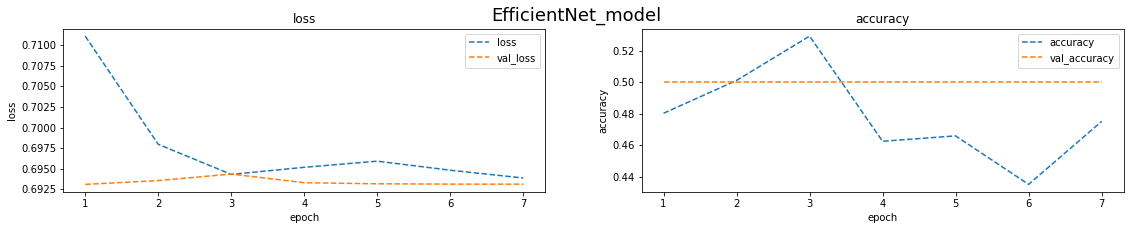

In [42]:
# plot model ouputs
plot_model_output(history_custom, 'custom_model')
plot_model_output(history_vgg19, 'VGG19_model')
plot_model_output(history_resnet, 'Resnet_model')
plot_model_output(history_inception_v3, 'inception_v3_model')
plot_model_output(history_EfficientNet, 'EfficientNet_model')

In [43]:
# get best model
best_model_df=pd.DataFrame(max_accuracy, columns=['model','accuracy'])
best_model_df.sort_values(by=['accuracy'], ascending=False, inplace=True)
best_model_df

,model,accuracy
0,model_custom.h5,0.958781
3,model_inception_v3.h5,0.939801
1,model_vgg19.h5,0.925805
2,model_resnet.h5,0.534126
4,model_EfficientNet.h5,0.529333


In [44]:
best_model=best_model_df.iloc[0]['model']

In [45]:
# load best model
load_model = tf.keras.models.load_model('models/'+best_model, compile = False)
load_model

In [46]:
#resnet_model.evaluate(test_generator)
#load_model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
#load_model.evaluate(test_generator)

In [47]:
predictions = load_model.predict(test_generator)

In [48]:
predictions[0:3]

array([[0.00904968],
       [0.01814331],
       [0.03374888]], dtype=float32)

In [49]:
filenames = test_generator.filenames
nb_samples = len(filenames)
steps = np.ceil(nb_samples/batch_size_val)
predict = load_model.predict_generator(test_generator, steps)

In [51]:
predictions_df=[]
for fn in filenames:
    predictions_df.append(fn.split('/'))
    
predictions_df=pd.DataFrame(predictions_df, columns=['class', 'image'])
predictions_df['class_pred']=np.rint(predict)
predictions_df = predictions_df.astype({'class_pred':'int'})
predictions_df['class_pred']=predictions_df['class_pred'].replace(0, 'NORMAL', regex=True)
predictions_df['class_pred']=predictions_df['class_pred'].replace(1, 'PNEUMONIA', regex=True)
predictions_df

,class,image,class_pred
0,NORMAL,IM-0001-0001.jpeg,NORMAL
1,NORMAL,IM-0003-0001.jpeg,NORMAL
2,NORMAL,IM-0005-0001.jpeg,NORMAL
3,NORMAL,IM-0006-0001.jpeg,NORMAL
4,NORMAL,IM-0007-0001.jpeg,NORMAL
...,...,...,...
619,PNEUMONIA,person96_bacteria_465.jpeg,PNEUMONIA
620,PNEUMONIA,person96_bacteria_466.jpeg,PNEUMONIA
621,PNEUMONIA,person97_bacteria_468.jpeg,PNEUMONIA
622,PNEUMONIA,person99_bacteria_473.jpeg,PNEUMONIA


In [52]:
print(classification_report(predictions_df['class'], predictions_df['class_pred']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.89      0.90       234
   PNEUMONIA       0.94      0.95      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



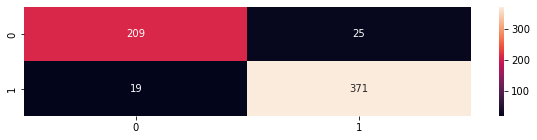

In [53]:
cm = confusion_matrix(predictions_df['class'], predictions_df['class_pred'])
plt.figure(figsize = (10, 2))
sns.heatmap(data=cm,annot=True, fmt='g');